# Setup

## Imports

In [1]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import the utilities and the dataloader
from utils import trainutil, inferutil, setuputil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)

# Import the funcs needed from utils
from utils.setuputil import setup_config, display_config
from utils.trainutil import train_model
from utils.inferutil import infer_one, infer_full


## Configuration

In [2]:
# Define the input config file
input_config = {
    # Environment and Model Info
    "env": "local",
    "approach": "bert",
    "model_name": "CustomSmallBertBaseCased",
    "model_base": "bert-base-cased",
    # System Configuration
    "device": "mps:0",
    "threads": 8,
    "seed": 42,
    # Data Configuration
    "data_dir": "../data",
    "data_ds": "manual",
    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 16,
    # Training Parameters
    "batch": 10,
    "lr": 1e-6,
    "mu": 0.25,
    "epochs": 10,
    "patience": 2,
    "save_int": 2,
    "save_dir": "../models/",
}
config = setup_config(input_config)
display_config(config)

Processing files: 100%|██████████| 40/40 [00:04<00:00,  8.11it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 10351.19it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 12756.40it/s]



5(P) = 5(G) + 0(E)

Configuration for BERT approach:
{
  "env": "local",
  "approach": "bert",
  "model_base": "bert-base-cased",
  "model_name": "CustomSmallBertBaseCased",
  "rows": 100,
  "cols": 100,
  "tokens": 16,
  "DEVICE": "mps",
  "THREADS": 8,
  "seed": 42,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BERT Tokenizer Object>",
  "train_loader": "<LoaderBert Object>",
  "val_loader": "<LoaderBert Object>",
  "test_loader": "<LoaderBert Object>",
  "batch": 10,
  "lr": 1e-06,
  "mu": 0.25,
  "epochs": 10,
  "patience": 2,
  "save_int": 2,
  "save_dir": "../models/",
  "save_name": "lber42_CustomSmallBertBaseCased_manual_100x100x16_bsz10lr1e-6ep10pa2"
}


In [10]:
# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]
# gber42_TinyBert_manual_100x100x32
# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config['model_base']

# Training parameters
batch_size = config["batch"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

## Checker Code for Loader Content

In [11]:
# # Check
# # Retrieve the first item's data from train_loader
# first_item = train_loader[0]

# # Extract tensors and file path
# x_tok = first_item['x_tok']
# x_masks = first_item['x_masks']
# y_tok = first_item['y_tok']
# file_path = first_item['file_paths']

# # Print the file path first
# print("File path:", file_path)

# # Print the shapes of the tensors
# print("Shape of x_tok:", x_tok.shape)
# print("Shape of x_masks:", x_masks.shape)
# print("Shape of y_tok:", y_tok.shape)

# # Define cell location
# row = 3
# col = 5

# # Extract data for the specific cell at (row, col)
# xtok_cell = x_tok[row, col, :]  # Tokenized input IDs for the cell
# xmask_cell = x_masks[row, col, :] if x_masks.numel() > 0 else None  # Attention mask for the cell (if applicable)
# ytok_cell = y_tok[row, col, :]  # Metadata tensor for the cell


# # Print extracted cell data
# print(f"\nx_tok at cell ({row}, {col}):\n", xtok_cell.tolist())
# if xmask_cell is not None:
#     print(f"\nx_masks at cell ({row}, {col}):\n", xmask_cell.tolist())
# print(f"\ny_tok at cell ({row}, {col}):\n", ytok_cell.tolist())

# # Decode x_tok of the cell into a list of words using the tokenizer
# decoded_words = tokenizer.decode(xtok_cell.tolist(), skip_special_tokens=False).split()
# print(f"\nDecoded words at cell ({row}, {col}):\n", decoded_words)


# Model Creation

In [12]:
# from transformers import BertConfig, BertModel
# import torch.nn as nn
# 
# 
# class CustomBertForCellClassification(nn.Module):
#     def __init__(self, dropout_rate=0.0):
#         super().__init__()
#         # Configuration with explicit initialization settings
#         self.config = BertConfig(
#             vocab_size=28996,
#             hidden_size=64,
#             num_hidden_layers=1,
#             num_attention_heads=4,
#             intermediate_size=256,
#             max_position_embeddings=512,
#             type_vocab_size=2,
#             layer_norm_eps=1e-12,
#             initializer_range=0.02,  # Explicit initialization range
#         )
# 
#         # Initialize BERT model with our config
#         self.bert = BertModel(self.config)
# 
#         # Carefully initialize embedding layers with smaller standard deviation
#         # This helps prevent initial predictions from being too extreme
#         self.bert.embeddings.word_embeddings.weight.data.normal_(mean=0.0, std=0.01)
#         self.bert.embeddings.position_embeddings.weight.data.normal_(mean=0.0, std=0.01)
#         self.bert.embeddings.token_type_embeddings.weight.data.normal_(
#             mean=0.0, std=0.01
#         )
# 
#         # Classification components
#         self.dropout = nn.Dropout(dropout_rate)
#         self.gelu = nn.GELU()
#         self.classifier = nn.Linear(64, 1)
# 
#         # Initialize classifier weights with small values to prevent extreme initial predictions
#         self.classifier.weight.data.normal_(mean=0.0, std=0.01)
#         self.classifier.bias.data.zero_()
# 
#     def forward(self, input_ids, attention_mask):
#         # Initialize output tensor
#         S_cube = torch.zeros(
#             (input_ids.shape[0], input_ids.shape[1], input_ids.shape[2]),
#             device=input_ids.device,
#         )
# 
#         # Process each cell
#         for cell in range(input_ids.shape[1] * input_ids.shape[2]):
#             row = cell // input_ids.shape[2]
#             col = cell % input_ids.shape[2]
# 
#             cell_input_ids = input_ids[:, row, col, :]
#             cell_attention_mask = attention_mask[:, row, col, :]
# 
#             outputs = self.bert(
#                 input_ids=cell_input_ids, attention_mask=cell_attention_mask
#             )
# 
#             pooled = self.dropout(outputs.pooler_output)
#             activated = self.gelu(pooled)
#             logits = self.classifier(activated)
# 
#             S_cube[:, row, col] = logits.view(-1)
# 
#         return S_cube

In [13]:
from transformers import BertModel, BertConfig
import torch.nn as nn
import torch
import math
from tqdm import tqdm

class SimpleBertEmbedAvg(nn.Module):
    def __init__(self, tokenizer, dropout_rate=0.1, imbalance_ratio=120.0):
        super().__init__()
        self.tokenizer = tokenizer
        
        self.config = BertConfig(
            vocab_size=30522,                      
            hidden_size=768,                       
            num_hidden_layers=2,                   
            num_attention_heads=4,                 
            intermediate_size=3072,                
            hidden_act="gelu",  # Using GELU like your original model
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=0.1,
            max_position_embeddings=512,           
            type_vocab_size=2,
            initializer_range=0.02,
            layer_norm_eps=1e-12,
            pad_token_id=0,
            position_embedding_type="absolute",
            use_cache=True
        )
        
        self.bert = BertModel.from_pretrained(
            'bert-base-uncased', 
            config=self.config,
            torch_dtype=torch.float16
        )
        
        self.dropout = nn.Dropout(dropout_rate)
        self.gelu = nn.GELU()  # Added GELU activation
        self.classifier = nn.Linear(768, 1)
        
        # Initialize classifier
        self.classifier.weight.data.normal_(mean=0.0, std=0.01)
        self.classifier.bias.data.fill_(-math.log(imbalance_ratio))

    def forward(self, input_ids, attention_mask):
        batch_size, rows, cols, seq_len = input_ids.shape
        S_cube = torch.zeros((batch_size, rows, cols), device=input_ids.device)
        
        # Process each cell with progress bar
        for cell in tqdm(range(rows * cols), desc="Processing cells"):
            row = cell // cols
            col = cell % cols
            
            # Get CLS token representation through BERT
            outputs = self.bert(
                input_ids=input_ids[:, row, col, :],
                attention_mask=attention_mask[:, row, col, :]
            )
            
            # Get pooled CLS representation and process through our layers
            pooled = self.dropout(outputs.pooler_output)
            activated = self.gelu(pooled)  # Added GELU activation
            logits = self.classifier(activated)
            S_cube[:, row, col] = logits.squeeze(-1)
        
        return S_cube

In [ ]:
import torch
import gc

# 1) First clear any existing tensors and cache
gc.collect()
torch.mps.empty_cache()

# Print initial memory (Note: MPS reports slightly differently than CUDA)
print("\nInitial MPS Memory:")
print(f"Allocated: {torch.mps.current_allocated_memory()/1e9:.2f} GB")

# 2) Create model and move to device
untrained_model = SimpleBertEmbedAvg(tokenizer=tokenizer, dropout_rate=0.1, imbalance_ratio=120.0).to(DEVICE)

print("\nAfter model creation:")
print(f"Allocated: {torch.mps.current_allocated_memory()/1e9:.2f} GB")

# 3) Get single example
check_loader = torch.utils.data.DataLoader(train_loader, batch_size=1, shuffle=False)
batch = next(iter(check_loader))

# 4) Move data to device
ex_xtok = batch["x_tok"].to(DEVICE)
ex_xmask = batch["x_masks"].to(DEVICE)

print("\nAfter data loading:")
print(f"Allocated: {torch.mps.current_allocated_memory()/1e9:.2f} GB")

# 5) Forward pass
with torch.no_grad():
    output = untrained_model(input_ids=ex_xtok, attention_mask=ex_xmask)

print("\nAfter forward pass:")
print(f"Allocated: {torch.mps.current_allocated_memory()/1e9:.2f} GB")

# 6) Clear everything
del output, ex_xtok, ex_xmask, untrained_model
gc.collect()
torch.mps.empty_cache()

print("\nAfter cleanup:")
print(f"Allocated: {torch.mps.current_allocated_memory()/1e9:.2f} GB")


Initial MPS Memory:
Allocated: 0.08 GB

After model creation:
Allocated: 0.08 GB

After data loading:
Allocated: 0.08 GB


Processing cells:   0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
# # Get a single batch directly from train_loader
# check_loader = torch.utils.data.DataLoader(train_loader, batch_size=2, shuffle=False)
# # Get the first batch
# batch = next(iter(check_loader))

# # Move data to device
# ex_xtok = batch["x_tok"].to(DEVICE)
# ex_xmask = batch["x_masks"].to(DEVICE)

# # Forward pass
# output = untrained_model(input_ids=ex_xtok, attention_mask=ex_xmask)

In [6]:
# Imports
import os  # For file and directory operations
import time  # For generating the timestamp in filenames
import torch  # Core PyTorch library
import torch.nn as nn  # For defining loss functions
import math  # For calculating exponential in perplexity calculation
from tqdm import tqdm  # For progress bars in training and validation loops
import sys
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim import AdamW


# ------------------------------------------------------------------------
# Define a new function to train the BertTiny model using attention masks
def train_bert(
    model,
    train_data,
    val_data,
    DEVICE,
    batch_size=8,
    lr=1.4e-5,
    mu=0.25,
    max_epochs=4,
    patience=3,
    save_int=2,
    save_dir="../models/",
    save_name="bert_",
    config=None,
):

    # --------------------------------------------------------------------
    # Everything remains the same up until we get to the forward pass.
    # We still set up logging, create train_loader, val_loader, define loss, etc.
    # --------------------------------------------------------------------

    # Set the option in torch to print full tensor
    torch.set_printoptions(profile="full")

    # Check if save_int > 0 and save_dir exists
    if save_int > 0 and not os.path.exists(save_dir):
        raise ValueError(f"Directory '{save_dir}' DNE")

    # Generate timestamp for naming checkpoints and logs
    timestamp = time.strftime("%Y%m%d_%H%M%S")

    # Construct checkpoint paths
    model_path = os.path.join(save_dir, f"{save_name}_{timestamp}.pth")
    log_file = os.path.join(save_dir, f"{save_name}_{timestamp}.txt")

    # Write config to log if provided (and remove non-serializable items)
    if config is not None and save_int > 0:
        import json
        import copy

        config_serializable = copy.deepcopy(config)
        del config_serializable["DEVICE"]
        del config_serializable["train_loader"]
        del config_serializable["val_loader"]
        del config_serializable["test_loader"]
        del config_serializable["tokenizer"]

        with open(log_file, "w") as log:
            log.write("\nFinal configuration:\n")
            log.write(json.dumps(config_serializable, indent=2))
            log.write("\n\n" + "=" * 80 + "\n\n")

    # --------------------------------------------------------------------
    # Create optimizer as before
    opt = torch.optim.Adagrad(model.parameters(), lr=lr)

    # Create the DataLoader for train and validation sets
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_data, batch_size=batch_size, shuffle=False
    )

    # Diagnostic check of label distribution
    print("\nChecking label distribution in training data:")
    total_ones = 0
    total_zeros = 0
    for batch in train_loader:
        labels = batch["y_tok"][:, :, :, 6].view(-1)
        total_ones += (labels == 1).sum().item()
        total_zeros += (labels == 0).sum().item()

    print(f"Number of 1s (bold): {total_ones}")
    print(f"Number of 0s (not bold): {total_zeros}")
    print(f"Ratio of bold to not bold: 1:{total_zeros/total_ones:.2f}")

    # Calculate class imbalance as before
    num_bold_cells = sum(
        (batch["y_tok"][:, :, :, 6] == 1).sum() for batch in train_loader
    )
    num_nonbold_cells = sum(
        (batch["y_tok"][:, :, :, 6] == 0).sum() for batch in train_loader
    )
    class_imbalance = num_nonbold_cells / num_bold_cells

    # Binary cross-entropy loss with logits
    loss_fn = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([class_imbalance], dtype=torch.float).to(DEVICE)
    )

    # Initialize training parameters
    epoch = 0
    best_avgtrloss = float("inf")
    best_perp = float("inf")
    best_epoch = 0
    best_avgvalloss = float("inf")
    best_valperp = float("inf")
    nimp_ctr = 0
    training = True

    # --------------------------------------------------------------------
    # Main training loop
    # --------------------------------------------------------------------
    while training and (epoch < max_epochs):

        print(f"Epoch {epoch}")
        if save_int > 0:
            with open(log_file, "a") as log:
                log.write(f"\nEpoch {epoch}\n")

        curr_trloss, curr_valloss = 0, 0

        # Put model in train mode
        model.train()

        # ----------------------------------------------------------------
        # Train step
        # ----------------------------------------------------------------
        for i, batch in enumerate(tqdm(train_loader, desc="Batch Processing")):

            # Zero out gradients
            model.zero_grad()

            # ----------------------------------------------------------------
            # CHANGED LINE: Now pass both input_ids and attention_mask to model
            logits = model(
                batch["x_tok"].to(DEVICE),
                batch["x_masks"].to(DEVICE),  # <--- Pass attention_mask here
            ).view(-1)

            # ----------------------------------------------------------------
            # Same as original: define labels
            labels = batch["y_tok"][:, :, :, 6].to(DEVICE).view(-1).float()

            # Monitor first batch of each epoch
            if i == 0:
                with torch.no_grad():
                    probs = torch.sigmoid(logits[:10])
                    print("\nFirst 10 predictions:", probs.cpu().numpy())
                    print("First 10 labels:", labels[:10].cpu().numpy())

            # Compute loss
            loss = loss_fn(logits, labels)

            # Accumulate training loss
            curr_trloss += loss.detach().cpu().item()

            # Backprop
            loss.backward()

            # Monitor gradients
            if i == 0:  # First batch of each epoch
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm**0.5
                print(f"Gradient norm: {total_norm}")

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=mu)

            # Update model parameters
            opt.step()

            # Clear memory
            del loss

        # Put model in eval mode
        model.eval()

        # ----------------------------------------------------------------
        # Validation step
        # ----------------------------------------------------------------
        for i, batch in enumerate(tqdm(val_loader, desc="Validation Processing")):
            with torch.no_grad():

                # ----------------------------------------------------------------
                # CHANGED LINE: Pass both input_ids and attention_mask to model
                val_logits = model(
                    batch["x_tok"].to(DEVICE),
                    batch["x_masks"].to(DEVICE),  # <--- Pass attention_mask here
                ).view(-1)

                # Labels remain the same
                val_labels = batch["y_tok"][:, :, :, 6].to(DEVICE).view(-1).float()

                # Compute validation loss
                val_loss = loss_fn(val_logits, val_labels)

                curr_valloss += val_loss.detach().cpu().item()

        # ----------------------------------------------------------------
        # Same perplexity calculations as original
        # ----------------------------------------------------------------
        curr_avgtrloss = curr_trloss / len(train_loader)
        curr_perp = math.exp(curr_trloss / (len(train_loader) * batch_size * 2500))
        curr_avgvalloss = curr_valloss / len(val_loader)
        curr_valperp = math.exp(curr_valloss / (len(val_loader) * batch_size * 2500))

        # Print stats
        print(f"Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}")
        print(f"Val Loss: {curr_avgvalloss}, Perplexity: {curr_valperp}\n")
        if save_int > 0:
            with open(log_file, "a") as log:
                log.write(f"Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}\n")
                log.write(f"Val Loss: {curr_avgvalloss}, Perplexity: {curr_valperp}\n")

        # Early stopping checks
        if curr_valperp < best_valperp:
            best_perp = curr_perp
            best_valperp = curr_valperp
            best_avgtrloss = curr_avgtrloss
            best_avgvalloss = curr_avgvalloss
            best_epoch = epoch
            nimp_ctr = 0
        else:
            nimp_ctr += 1

        if nimp_ctr >= patience:
            print(f"\nEARLY STOPPING at epoch {epoch}, best epoch {best_epoch}")
            print(f"Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")
            print(f"Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}")
            if save_int > 0:
                with open(log_file, "a") as log:
                    log.write(
                        f"\nEARLY STOPPING at epoch {epoch}, best epoch {best_epoch}\n"
                    )
                    log.write(
                        f"Train Loss = {best_avgtrloss}, Perplexity = {best_perp}\n"
                    )
                    log.write(
                        f"Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}\n"
                    )
            training = False

        # Save model periodically
        if save_int > 0 and (epoch + 1) % save_int == 0:
            torch.save(model.state_dict(), model_path)
            print("Model Saved")
            with open(log_file, "a") as log:
                log.write("Model Saved\n")

        epoch += 1
        print()

    # Final save
    if save_int > 0:
        torch.save(model.state_dict(), model_path)

    # Print final results
    print(f"\nTRAINING DONE at epoch {epoch-1}, best epoch {best_epoch}")
    print(f"Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")
    print(f"Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}")
    if save_int > 0:
        with open(log_file, "a") as log:
            log.write(f"\nTRAINING DONE at epoch {epoch-1}, best epoch {best_epoch}\n")
            log.write(f"Train Loss = {best_avgtrloss}, Perplexity = {best_perp}\n")
            log.write(f"Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}\n")

    return model

In [ ]:
# Train with adjusted batch size
trained_model = train_bert(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=10,        # Increased from 2 to 10 since we have single layer
    lr=2e-5,             # Standard BERT fine-tuning learning rate
    mu=0.25,             # Gradient clipping
    max_epochs=10,        # Give it more epochs to learn
    patience=3,
    save_int=2,
    save_dir=save_dir,
    save_name=save_name,
    config=config
)


Checking label distribution in training data:
Number of 1s (bold): 3286
Number of 0s (not bold): 396714
Ratio of bold to not bold: 1:120.73
Epoch 0


Batch Processing:   0%|                                                                                                             | 0/4 [00:00<?, ?it/s]


First 10 predictions: [0.50190187 0.5018195  0.50231576 0.5017811  0.5019873  0.50178313
 0.50204724 0.50158155 0.50136065 0.5027875 ]
First 10 labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Batch Processing:  25%|█████████████████████████▎                                                                           | 1/4 [00:32<01:38, 32.88s/it]

Gradient norm: 0.04761283842969666


Validation Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.83s/it]


Train Loss: 1.3749155104160309, Perplexity: 1.0000549981327584
Val Loss: 1.3538637161254883, Perplexity: 1.0000541560150291


Epoch 1


Batch Processing:   0%|                                                                                                             | 0/4 [00:00<?, ?it/s]


First 10 predictions: [0.5013529  0.50141186 0.5016601  0.5017683  0.5021611  0.5018736
 0.50185126 0.50190675 0.5012533  0.5019994 ]
First 10 labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Batch Processing:  25%|█████████████████████████▎                                                                           | 1/4 [00:29<01:28, 29.35s/it]

Gradient norm: 0.04895694333932419


Validation Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.98s/it]


Train Loss: 1.3749186098575592, Perplexity: 1.000054998256743
Val Loss: 1.3538556098937988, Perplexity: 1.0000541556907623

Model Saved

Epoch 2


Batch Processing:   0%|                                                                                                             | 0/4 [00:00<?, ?it/s]


First 10 predictions: [0.50146264 0.5018106  0.50123703 0.50166535 0.50253314 0.5021774
 0.50143903 0.5010613  0.5022363  0.50140446]
First 10 labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Batch Processing:  25%|█████████████████████████▎                                                                           | 1/4 [00:29<01:28, 29.40s/it]

Gradient norm: 0.0462448151670709


Validation Processing:   0%|                                                                                                        | 0/1 [00:00<?, ?it/s]


Filename: ../../../data/farzan/manual_train/advanced-placement-mathematics-enrollment (1).xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,11): 0.49012288451194763184
(5,3): 0.49013239145278930664
(3,21): 0.49015477299690246582
(1,1): 0.49019140005111694336
(4,15): 0.49021363258361816406
(4,13): 0.49024009704589843750
(4,9): 0.49024662375450134277
(4,5): 0.49024862051010131836
(3,1): 0.49025705456733703613
(4,3): 0.49028709530830383301
(5,4): 0.49029120802879333496
(4,7): 0.49032294750213623047
(3,17): 0.49033865332603454590
(3,3): 0.49036487936973571777
(3,2): 0.49038097262382507324
(3,22): 0.49040454626083374023
(3,19): 0.49044704437255859375

NB to B ratio: Predicted = 0:10000 | Actual = 9937:63
Accuracy: 0.63% | Precision: 0.63% | Recall: 100.00% | F1-Score: 0.01



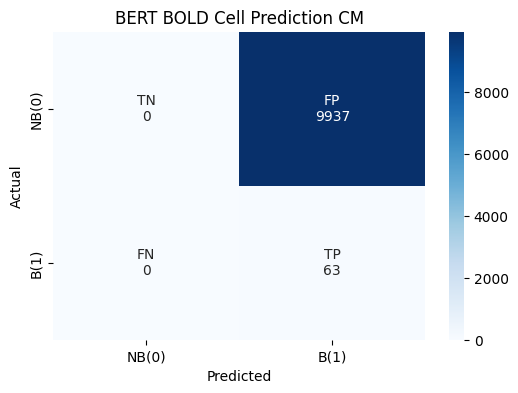


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


In [21]:
from utils import inferutil
importlib.reload(inferutil)
from utils.inferutil import binfer_one

# Params
loc = 0
thresh = 0.5
cond = '>'
disp_max=True

# inference on single position of train loader params
binfer_one(
    trained_model,
    train_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../../../data/farzan/manual_val/ffelbydefermenttype.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(11,0): 0.49005827307701110840
(15,0): 0.49011784791946411133
(5,14): 0.49012970924377441406
(5,4): 0.49016880989074707031
(5,10): 0.49017512798309326172
(6,3): 0.49017524719238281250
(5,6): 0.49018353223800659180
(5,8): 0.49018564820289611816
(5,12): 0.49018707871437072754
(8,1): 0.49018973112106323242
(23,0): 0.49019521474838256836
(7,0): 0.49020284414291381836
(5,16): 0.49022644758224487305
(19,0): 0.49023699760437011719
(10,1): 0.49023768305778503418
(7,1): 0.49024444818496704102
(9,1): 0.49027884006500244141
(5,2): 0.49028891324996948242
(6,0): 0.49030587077140808105
(6,2): 0.49030902981758117676
(0,0): 0.49030953645706176758
(27,0): 0.49036991596221923828
(31,0): 0.49038735032081604004

NB to B ratio: Predicted = 9425:575 | Actual = 9896:104
Accuracy: 95.29% | Precision: 18.09% | Recall: 100.00% | F1-Score: 0.31



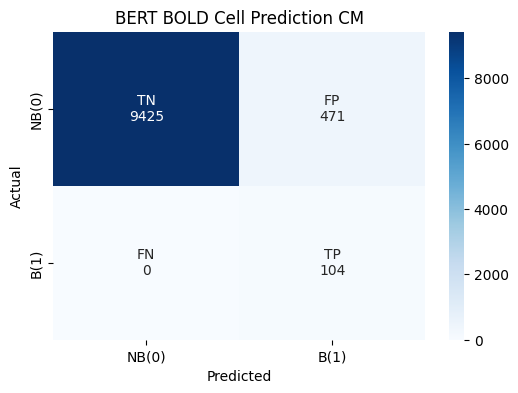


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
10,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
11,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
binfer_one(
    trained_model,
    val_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../../../data/farzan/manual_test/Harassment-Bullying-on-basis-of-sex_disciplined.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,11): 0.49012288451194763184
(5,3): 0.49013239145278930664
(3,23): 0.49015477299690246582
(4,15): 0.49021363258361816406
(4,13): 0.49024009704589843750
(5,18): 0.49024170637130737305
(4,9): 0.49024662375450134277
(4,5): 0.49024862051010131836
(3,1): 0.49025705456733703613
(3,19): 0.49027040600776672363
(1,1): 0.49028301239013671875
(4,3): 0.49028709530830383301
(5,4): 0.49029120802879333496
(6,1): 0.49030128121376037598
(4,7): 0.49032294750213623047
(3,17): 0.49033865332603454590
(3,3): 0.49036487936973571777
(3,2): 0.49038097262382507324
(3,24): 0.49040454626083374023
(3,21): 0.49044704437255859375

NB to B ratio: Predicted = 8538:1462 | Actual = 9930:70
Accuracy: 86.08% | Precision: 4.79% | Recall: 100.00% | F1-Score: 0.09



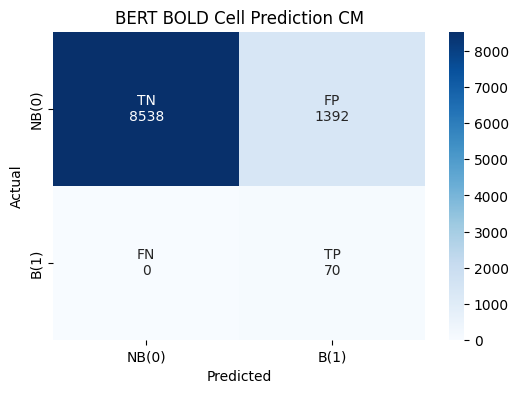


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
10,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
11,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
binfer_one(
    trained_model,
    test_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)